In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
teacher_learning_rate = 0.0005 # 0.096779
student_learning_rate = teacher_learning_rate
teacher_epochs = 2 #200
student_epochs = teacher_epochs
teacher_patience = 10
student_patience = 6
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 50
num_workers = 4
epsilon = 0.05
margin = 0.01
num_classes = 16
base_save_dir = "Test_Dir2"

# list of lambda values to loop through for grid search
teacher_lambda_factor_list = [0,50]
student_lambda_factor_list = [0,50]

In [3]:
# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
class_names_new = [f"Class {label}" for label in range(num_classes)]


In [4]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [5]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [6]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)

    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Outputting a single value for bias

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        

In [13]:
def train_teacher(teacher, teacher_optimizer, teacher_loss_fn, critic, critic_optimizer, critic_loss_fn,
                  lambda_factor, epsilon=epsilon, margin=margin, patience=teacher_patience, 
                  epochs=teacher_epochs, device=device, base_save_dir=base_save_dir):
    
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    train_critic_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    val_critic_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    teacher_best_model_state = None

    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)

    print(f'Training Teacher with Lambda Value of {lambda_factor}')
    
    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        
        # Training
        teacher.train()
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
    
            # Forward pass through actor
            teacher_output = teacher(images)
            class_predictions = torch.argmax(teacher_output, dim=1)
    
            # Compute bias
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)
    
            critic_optimizer.zero_grad()
            
            for param in critic.parameters():
                param.requires_grad = True
            for param in teacher.parameters():
                param.requires_grad = False
                
            critic.train()
            teacher.eval()
            
            critic_output = critic(teacher_output)
            critic_loss = critic_loss_fn(critic_output, bias_mean)
            critic_loss.backward(retain_graph=True)
    
            critic_optimizer.step()
    
            for param in critic.parameters():
                param.requires_grad = False
            for param in teacher.parameters():
                param.requires_grad = True
                
            teacher.train()
            critic.eval()
    
            teacher_optimizer.zero_grad()
    
            critic_output = critic(teacher_output)
            main_loss = teacher_loss_fn(teacher_output, labels)
    
            combined_loss = max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss
    
            combined_loss.backward(retain_graph=True)
            teacher_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
            epoch_train_disparities.append(bias)
        
            # Record the losses
            epoch_train_losses.append((combined_loss.item(), main_loss.item(), critic_loss.item()))
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_combined_loss = np.mean([x[0] for x in epoch_train_losses])
        train_main_loss = np.mean([x[1] for x in epoch_train_losses])
        train_critic_loss = np.mean([x[2] for x in epoch_train_losses])
    
        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_losses.append(train_combined_loss)
        train_main_losses.append(train_main_loss)
        train_critic_losses.append(train_critic_loss)
    
        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        teacher.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                teacher_output = teacher(images)
                val_critic_output = critic(teacher_output)
                class_predictions = torch.argmax(teacher_output, dim=1)
        
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                mean_batch_bias = torch.tensor([batch_bias], device=device, dtype=torch.float32)
                val_main_loss = teacher_loss_fn(teacher_output, labels)
                val_critic_loss = critic_loss_fn(val_critic_output, mean_batch_bias)
        
                val_combined_loss = max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss
    
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append((val_combined_loss.item(), val_main_loss.item(), val_critic_loss.item()))
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_combined_loss = np.mean([x[0] for x in epoch_val_losses])
            val_main_loss = np.mean([x[1] for x in epoch_val_losses])
            val_critic_loss = np.mean([x[2] for x in epoch_val_losses])
        
            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_losses.append(val_combined_loss)
            val_main_losses.append(val_main_loss)
            val_critic_losses.append(val_critic_loss)

            # Check if current validation combined loss is lower than the best combined loss
        if val_combined_loss < best_val_loss:
            best_val_loss = val_combined_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            teacher_best_model_state = {
                'epoch': epoch,
                'teacher_state_dict': teacher.state_dict(),
                'critic_state_dict': critic.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lambda_factor}.pth')
            torch.save(teacher_best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"TEACHER - Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Combined Loss: {train_combined_loss:.6f}, VALIDATION Combined Loss: {val_combined_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Teacher Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Teacher Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_losses, label='Training Combined Loss')
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.plot(train_critic_losses, label='Training Critic Loss')
        plt.title('Teacher Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_losses, label='Validation Combined Loss')
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.plot(val_critic_losses, label='Validation Critic Loss')
        plt.title('Teacher Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = teacher_best_model_state['epoch'] + 1 if teacher_best_model_state else epochs
    print(f"Finished Training TEACHER with lambda value of {lambda_factor}. Best epoch number: {best_epoch}")

    return teacher_best_model_state

In [20]:
def train_student(student, teacher, student_optimizer, student_loss_fn, critic, critic_optimizer, critic_loss_fn,
                  lambda_factor, epsilon=epsilon, margin=margin, patience=student_patience, 
                  epochs=student_epochs, device=device, base_save_dir=base_save_dir):
    
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    train_critic_losses = []
    train_kd_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    val_critic_losses = []
    val_kd_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    student_best_model_state = None

    teacher.eval()
    teacher.to(device)
    
    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)

    print(f'Training Student with Lambda Value of {lambda_factor}')

    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        
        # Training
        student.train()
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
    
            # Forward pass through actor
            student_output = student(images)
            class_predictions = torch.argmax(student_output, dim=1)
            
            with torch.no_grad():
                teacher_outputs = teacher(images)
                
            # Compute bias
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)
    
            critic_optimizer.zero_grad()
            
            for param in critic.parameters():
                param.requires_grad = True
            for param in student.parameters():
                param.requires_grad = False
                
            critic.train()
            student.eval()
            
            critic_output = critic(student_output)
            critic_loss = critic_loss_fn(critic_output, bias_mean)
            critic_loss.backward(retain_graph=True)
    
            critic_optimizer.step()
    
            for param in critic.parameters():
                param.requires_grad = False
            for param in student.parameters():
                param.requires_grad = True
                
            student.train()
            critic.eval()
    
            student_optimizer.zero_grad()
    
            critic_output = critic(student_output)
            main_loss = student_loss_fn(student_output, labels)

            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
            else:
                kd_loss = 0 
            
            combined_loss = alpha * kd_loss + (1 - alpha) * max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss
    
            combined_loss.backward(retain_graph=True)
            student_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
            epoch_train_disparities.append(bias)
        
            # Record the losses
            epoch_train_losses.append((combined_loss.item(), main_loss.item(), critic_loss.item(), kd_loss.item()))
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_combined_loss = np.mean([x[0] for x in epoch_train_losses])
        train_main_loss = np.mean([x[1] for x in epoch_train_losses])
        train_critic_loss = np.mean([x[2] for x in epoch_train_losses])
        train_kd_loss = np.mean([x[3] for x in epoch_train_losses])

        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_losses.append(train_combined_loss)
        train_main_losses.append(train_main_loss)
        train_critic_losses.append(train_critic_loss)
        train_kd_losses.append(train_kd_loss)

        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        student.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                student_output = student(images)
                val_critic_output = critic(student_output)
                class_predictions = torch.argmax(student_output, dim=1)
                teacher_output = teacher(images)
                
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                mean_batch_bias = torch.tensor([batch_bias], device=device, dtype=torch.float32)
                val_main_loss = student_loss_fn(student_output, labels)
                val_critic_loss = critic_loss_fn(val_critic_output, mean_batch_bias)
                kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = kd_loss.sum()
                else:
                    val_kd_loss = 0     
                
                val_combined_loss = alpha * val_kd_loss + (1 - alpha) * max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss
    
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append((val_combined_loss.item(), val_main_loss.item(), val_critic_loss.item(), val_kd_loss.item()))
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_combined_loss = np.mean([x[0] for x in epoch_val_losses])
            val_main_loss = np.mean([x[1] for x in epoch_val_losses])
            val_critic_loss = np.mean([x[2] for x in epoch_val_losses])
            val_kd_loss = np.mean([x[3] for x in epoch_val_losses])

            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_losses.append(val_combined_loss)
            val_main_losses.append(val_main_loss)
            val_critic_losses.append(val_critic_loss)
            val_kd_losses.append(val_kd_loss)

            # Check if current validation combined loss is lower than the best combined loss
        if val_combined_loss < best_val_loss:
            best_val_loss = val_combined_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            student_best_model_state = {
                'epoch': epoch,
                'student_state_dict': student.state_dict(),
                'critic_state_dict': critic.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lambda_factor}.pth')
            torch.save(student_best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"STUDENT - Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Combined Loss: {train_combined_loss:.6f}, VALIDATION Combined Loss: {val_combined_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Student Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Student Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_losses, label='Training Combined Loss')
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.plot(train_critic_losses, label='Training Critic Loss')
        plt.plot(train_kd_losses, label='Training KD Loss')
        plt.title('Student Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_losses, label='Validation Combined Loss')
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.plot(val_critic_losses, label='Validation Critic Loss')
        plt.plot(val_kd_losses, label='Validation KD Loss')
        plt.title('Student Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = student_best_model_state['epoch'] + 1 if student_best_model_state else epochs
    print(f"Finished Training STUDENT with lambda value of {lambda_factor}. Best epoch number: {best_epoch}")

    return student_best_model_state

Training Teacher with Lambda Value of 0


Epoch 1/2, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:18<00:00,  3.89it/s]



TEACHER - Lambda 0 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.529573, VALIDATION Accuracy: 0.6182
TRAINING Disparity: 0.105771, VALIDATION Disparity: 0.1737
TRAINING Combined Loss: 1.556121, VALIDATION Combined Loss: 1.2428
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.03357272143399315
Class Celebration: Val Disparity = -0.013953488372092981
Class Parade: Val Disparity = 0.028913601368691144
Class Waiter_Or_Waitress: Val Disparity = 0.09107720758206195
Class Individual_Sports: Val Disparity = -0.21846130546721187
Class Surgeons: Val Disparity = 0.022172949002217335
Class Spa: Val Disparity = -0.68
Class Law_Enforcement: Val Disparity = 0.13688688688688688
Class Business: Val Disparity = -0.10796970020270996
Class Dresses: Val Disparity = -0.6951219512195123
Class Water_Activities: Val Disparity = 0.15935135135135126
Class Picnic: Val Disparity = 1.1102230246251565e-16
Class Rescue: Val Disparit

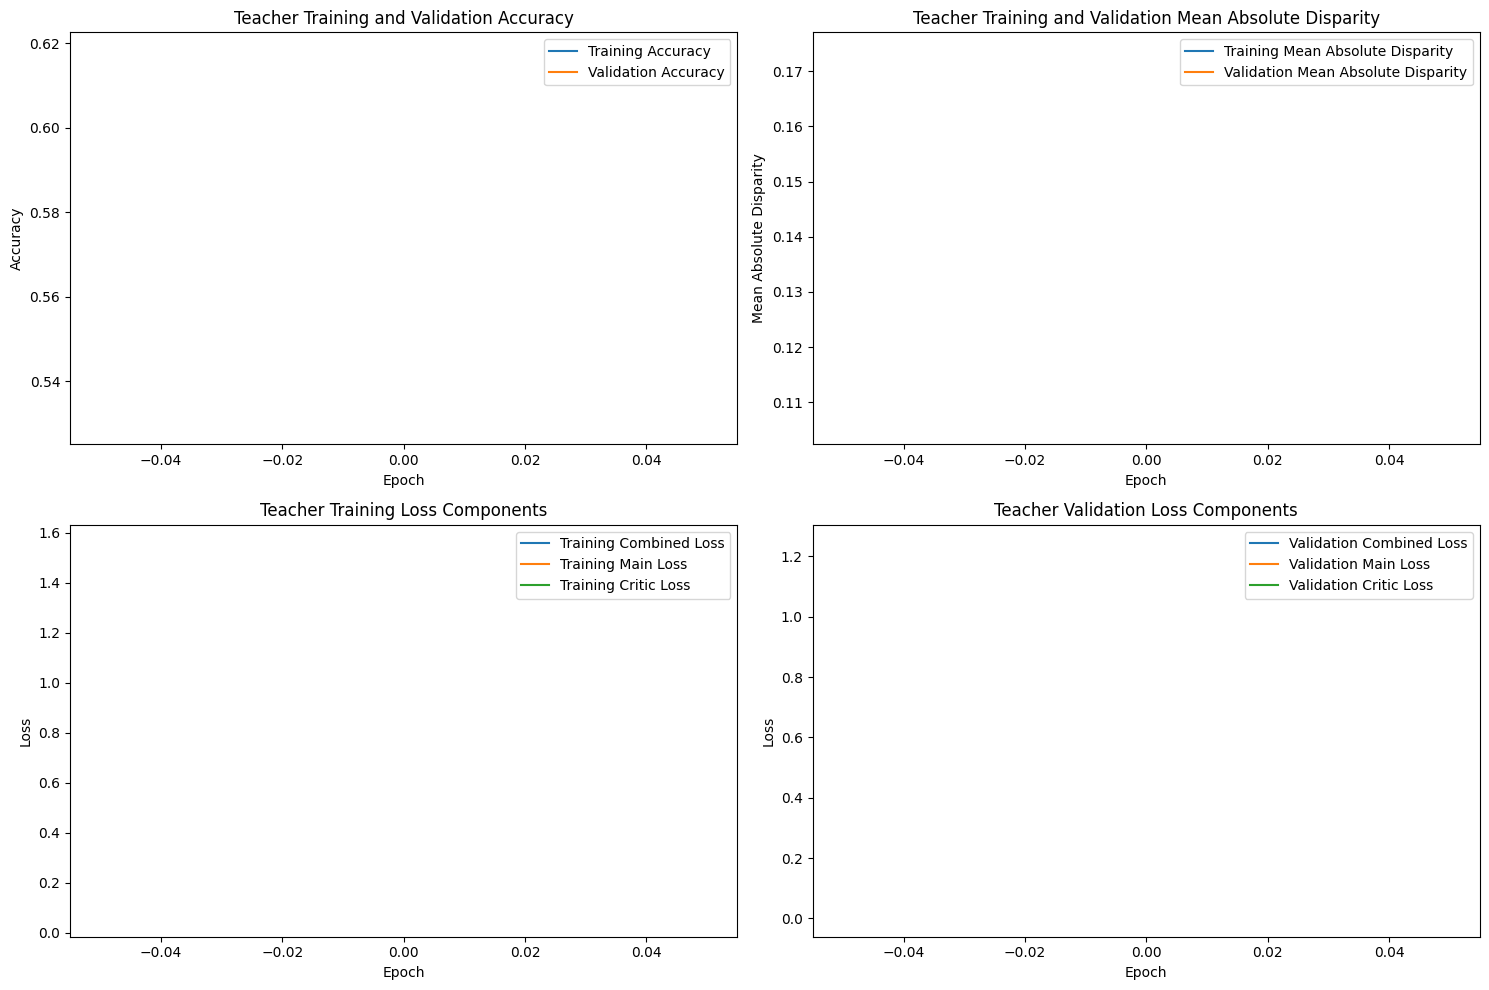

Epoch 2/2, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:17<00:00,  3.96it/s]



TEACHER - Lambda 0 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.714034, VALIDATION Accuracy: 0.6511
TRAINING Disparity: 0.102180, VALIDATION Disparity: 0.2009
TRAINING Combined Loss: 0.946268, VALIDATION Combined Loss: 1.1970
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.12796169790389444
Class Celebration: Val Disparity = 0.12325581395348828
Class Parade: Val Disparity = -0.011348731109210197
Class Waiter_Or_Waitress: Val Disparity = -0.043920480813684826
Class Individual_Sports: Val Disparity = -0.16488717249734985
Class Surgeons: Val Disparity = -0.16038433111603845
Class Spa: Val Disparity = -0.8400000000000001
Class Law_Enforcement: Val Disparity = 0.10835835835835839
Class Business: Val Disparity = -0.12866744905579858
Class Dresses: Val Disparity = -0.7303523035230352
Class Water_Activities: Val Disparity = 0.08735135135135141
Class Picnic: Val Disparity = 0.09090909090909094
Class Rescue: 

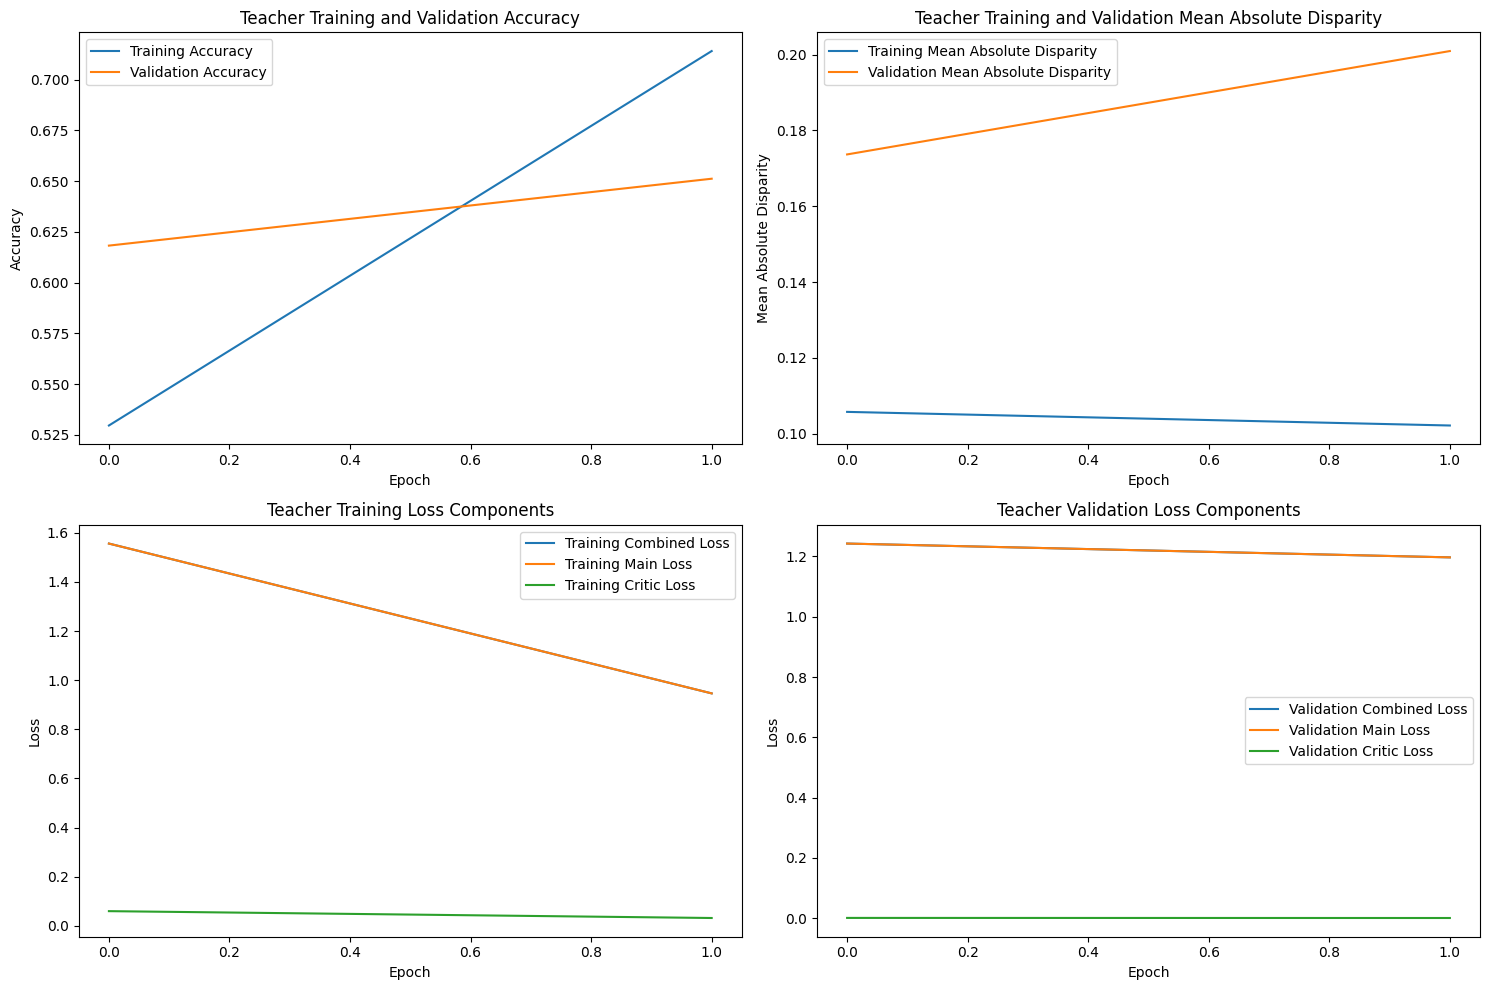

Finished Training TEACHER with lambda value of 0. Best epoch number: 2
Training Teacher with Lambda Value of 50


Epoch 1/2, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:18<00:00,  3.84it/s]



TEACHER - Lambda 50 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.255531, VALIDATION Accuracy: 0.2777
TRAINING Disparity: 0.023171, VALIDATION Disparity: 0.0412
TRAINING Combined Loss: 10.482457, VALIDATION Combined Loss: 2.7364
--------------------------------------------------

Class Team_Sports: Val Disparity = -0.008127517954107488
Class Celebration: Val Disparity = -0.01395348837209301
Class Parade: Val Disparity = -0.009637867122896937
Class Waiter_Or_Waitress: Val Disparity = -0.032824780397595926
Class Individual_Sports: Val Disparity = 0.14012570043919426
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.03278278278278285
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.0
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.05063291139240506
Class Cheering: Val Disparity = 0.0
Class Performance_And_

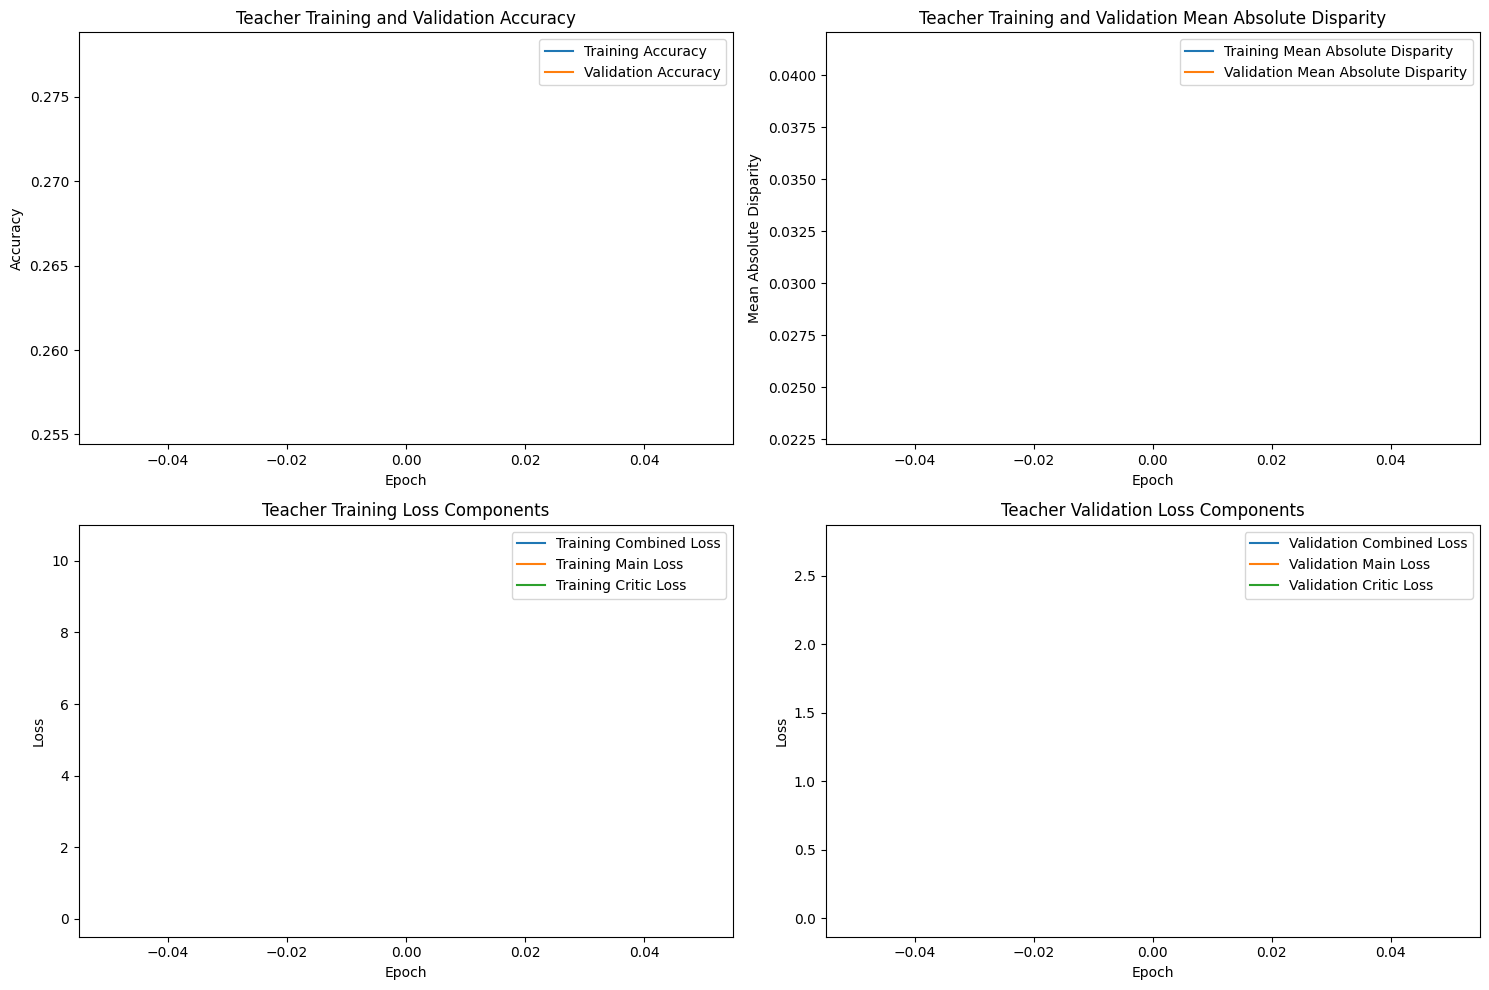

Epoch 2/2, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:17<00:00,  3.91it/s]



TEACHER - Lambda 50 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.280998, VALIDATION Accuracy: 0.3160
TRAINING Disparity: 0.037941, VALIDATION Disparity: 0.0670
TRAINING Combined Loss: 2.984648, VALIDATION Combined Loss: 2.5331
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.0415367548315525
Class Celebration: Val Disparity = -0.016279069767441867
Class Parade: Val Disparity = -0.046934702024522434
Class Waiter_Or_Waitress: Val Disparity = -0.14748035136384655
Class Individual_Sports: Val Disparity = 0.09283658942904738
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.17317317317317316
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.09686486486486487
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.012658227848101266
Class Cheering: Val Disparity = -0.0028712059

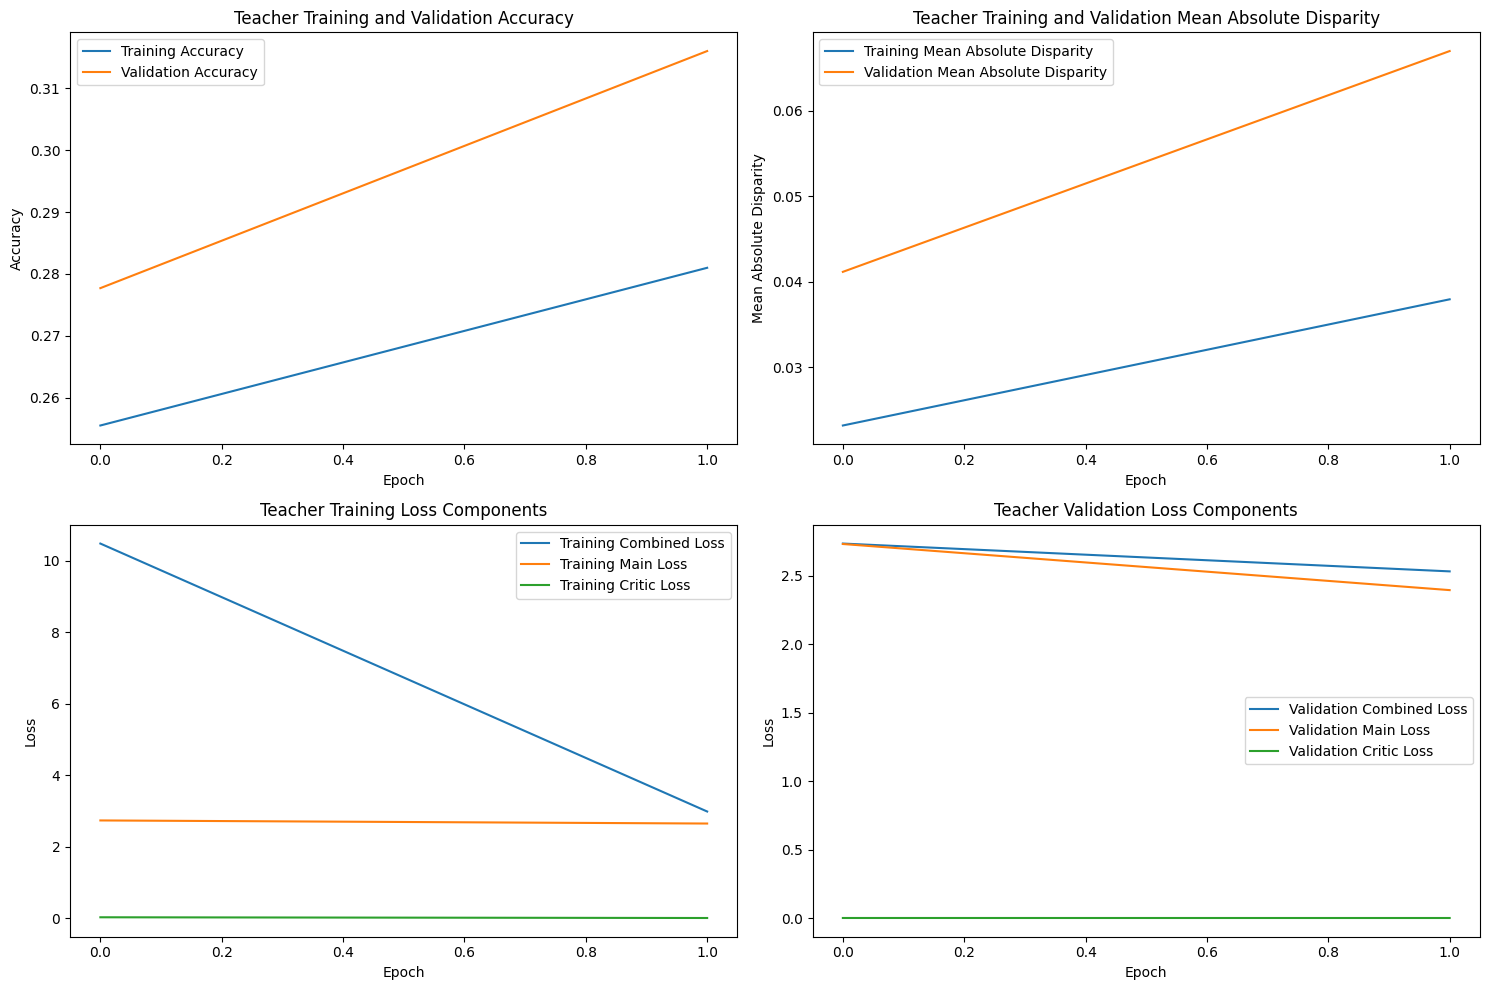

Finished Training TEACHER with lambda value of 50. Best epoch number: 2


In [15]:
# TEACHER
# Create dict to store best model states
teacher_model_states_best = {}

# Loop through the lambda_factor_list
for lambda_factor in teacher_lambda_factor_list:
    # Load EfficientNet B2 model for Teacher
    teacher = models.efficientnet_b2(pretrained=True)
    
    # Determine the number of output features from the feature extractor part of EfficientNet B2
    num_ftrs = teacher.classifier[1].in_features
    
    # Modify the classifier layer of the EfficientNet model to match your number of classes
    teacher.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Move the EfficientNet model to the GPU
    teacher = teacher.to(device)

    # Initialize the Critic model
    critic = Critic(input_size=num_classes).to(device)  # Adjust the input size based on your model's output
    critic_optimizer = optim.Adam(critic.parameters(), lr=teacher_learning_rate)
    critic_loss_fn = torch.nn.MSELoss()
    
    # Redefine your main model optimizer if needed
    teacher_optimizer = optim.Adam(teacher.parameters(), lr=teacher_learning_rate)
    teacher_loss_fn = nn.CrossEntropyLoss()

    # Train the model
    teacher_best_model_state = train_teacher(teacher, teacher_optimizer, teacher_loss_fn, critic, critic_optimizer, critic_loss_fn,
                                   lambda_factor, epsilon, margin, teacher_patience, teacher_epochs, device, base_save_dir=base_save_dir)
    teacher_model_states_best[lambda_factor] = teacher_best_model_state


In [23]:
# STUDENT
# Create dict to store best model states
student_model_states_best = {}

# load teacher model with lambda 0
lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_0')
teacher_lambda_0_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_0.pth')
teacher = torch.load(teacher_lambda_0_path)

# Loop through the lambda_factor_list
for lambda_factor in student_lambda_factor_list:
    # Load EfficientNet B0 model for Student
    student = models.efficientnet_b0(pretrained=True)
    
    # Determine the number of output features from the feature extractor part of EfficientNet B0
    num_ftrs = student.classifier[1].in_features  # This is the correct number of input features for your adversarial classifier
    
    # Modify the classifier layer of the EfficientNet model to match your number of classes
    student.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Move the EfficientNet model to the GPU
    student = student.to(device)

    # Initialize the Critic model
    critic = Critic(input_size=num_classes).to(device)  # Adjust the input size based on your model's output
    critic_optimizer = optim.Adam(critic.parameters(), lr=student_learning_rate)
    critic_loss_fn = torch.nn.MSELoss()
    
    # Redefine your main model optimizer if needed
    student_optimizer = optim.Adam(student.parameters(), lr=student_learning_rate)
    student_loss_fn = nn.CrossEntropyLoss()

    # Train the model
    student_best_model_state = train_student(student, teacher, student_optimizer, student_loss_fn, critic, critic_optimizer, critic_loss_fn,
                                   lambda_factor, epsilon, margin, student_patience, student_epochs, device, base_save_dir=base_save_dir)
    student_model_states_best[lambda_factor] = student_best_model_state


AttributeError: 'dict' object has no attribute 'eval'

In [19]:
teacher

{'epoch': 1,
 'teacher_state_dict': OrderedDict([('features.0.0.weight',
               tensor([[[[ 3.6786e-02,  6.8162e-02,  2.4306e-02],
                         [ 5.5096e-01,  2.9152e-01, -3.8916e-02],
                         [ 7.8248e-01,  2.3195e-01, -8.0200e-02]],
               
                        [[-2.9465e-01, -2.2663e-01,  4.5003e-02],
                         [-1.0972e+00, -7.1417e-01, -5.2812e-02],
                         [-1.4422e+00, -6.2890e-01, -1.2159e-02]],
               
                        [[ 2.2682e-01,  1.2954e-01, -2.5421e-02],
                         [ 6.3066e-01,  4.4930e-01,  4.7700e-02],
                         [ 6.7797e-01,  4.6074e-01,  6.2065e-03]]],
               
               
                       [[[-3.9470e-02, -2.2340e-02,  1.5487e-02],
                         [ 5.2832e-02, -2.0008e-01,  1.4069e-01],
                         [ 8.8106e-02, -9.3594e-01,  9.1985e-01]],
               
                        [[-8.3232e-02, -2.8977e-02

In [ ]:
# load models
collective_save_path = os.path.join(base_save_dir, 'student_model_states_best.pth')

# Load the saved model states
student_model_states_best = torch.load(collective_save_path)

# Example: Accessing the best_val_accuracy for a specific lambda value
lambda_value = 50
    if lambda_value in all_best_model_states:
        best_model_state = all_best_model_states[lambda_value]
        best_val_accuracy = best_model_state['best_val_accuracy']
        print(f"Best validation accuracy for lambda {lambda_value}: {best_val_accuracy}")
    else:
        print(f"No model state found for lambda {lambda_value}")

In [ ]:
# add plots

In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (num_images + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda4.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

for i in range(num_classes):
    # Display images with details
    print('#'*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('#'*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=10, cols=5)
